# Imdb review

In [25]:
import tensorflow_datasets as tfds
imdb, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)

In [26]:
import numpy as np

train_dataset, test_dataset = imdb['train'], imdb['test']

train_sentences = []
test_sentences = []
train_labels = []
test_labels = []

for s, l in train_dataset:
  train_sentences.append(s.numpy().decode('utf8'))
  train_labels.append(l.numpy())

for s, l in test_dataset:
  test_sentences.append(s.numpy().decode('utf8'))
  test_labels.append(l.numpy())

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
oov_token = '<OOV>'
pad_type = 'pre'
trunc_type = 'post'
max_length = 120

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

## Preparing Model

In [28]:
import tensorflow as tf

embedding_dims = 16

model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dims, input_length=max_length),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [29]:
num_epochs = 10
model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels))

Epoch 1/10
782/782 [==============================] - 8s 10ms/step - loss: 0.4924 - accuracy: 0.7442 - val_loss: 0.3427 - val_accuracy: 0.8497
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 0.2417 - accuracy: 0.9084 - val_loss: 0.3653 - val_accuracy: 0.8400
Epoch 3/10
782/782 [==============================] - 8s 10ms/step - loss: 0.0988 - accuracy: 0.9745 - val_loss: 0.4366 - val_accuracy: 0.8313
Epoch 4/10
782/782 [==============================] - 8s 10ms/step - loss: 0.0267 - accuracy: 0.9962 - val_loss: 0.5210 - val_accuracy: 0.8285
Epoch 5/10
782/782 [==============================] - 8s 10ms/step - loss: 0.0066 - accuracy: 0.9995 - val_loss: 0.5972 - val_accuracy: 0.8259
Epoch 6/10
782/782 [==============================] - 8s 11ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.6384 - val_accuracy: 0.8282
Epoch 7/10
782/782 [==============================] - 8s 10ms/step - loss: 9.2523e-04 - accuracy: 1.0000 - val_loss: 0.6878 - val_accuracy: 0.

In [30]:
e = model.layers[0]
weights = e.get_weights()[0]
weights.shape

(10000, 16)

In [7]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = tokenizer.index_word[word_num]
  embeddings = weights[word_num]
  
  out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
  out_m.write(word + '\n')

out_v.close()
out_m.close()

In [8]:
from google.colab import files
files.download('vecs.tsv')
files.download('meta.tsv')

# upload @ http://projector.tensorflow.org/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
sentence = 'T really think this is amazing. honest.'
sequence = tokenizer.texts_to_sequences([sentence])
padded = pad_sequences(sequence, maxlen=max_length)
model.predict([padded])

array([[0.7701964]], dtype=float32)

# Sarcasm Dataset

In [10]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-07-23 13:20:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2020-07-23 13:20:25 (121 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [11]:
import json
import numpy as np

with open('/tmp/sarcasm.json', 'r') as f:
  dataset = json.load(f)

headlines = []
labels = []

for i in dataset:
  headlines.append(i['headline'])
  labels.append(i['is_sarcastic'])

In [12]:
training_size = 20000

train_sentences = headlines[:training_size]
train_labels = labels[:training_size]
test_sentences = headlines[training_size:]
test_labels = labels[training_size:]

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
oov_token = '<OOV>'
pad_type = 'post'
trunc_type = 'post'
max_length = 120

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length)


train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

## Preparing Model

In [14]:
import tensorflow as tf

embedding_dims = 16

model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dims, input_length=max_length),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [15]:
num_epochs = 10
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels))

Epoch 1/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5804 - accuracy: 0.6791 - val_loss: 0.6765 - val_accuracy: 0.5633
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3659 - accuracy: 0.8870 - val_loss: 0.7287 - val_accuracy: 0.4367
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2545 - accuracy: 0.9346 - val_loss: 0.8726 - val_accuracy: 0.4367
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1804 - accuracy: 0.9603 - val_loss: 0.7276 - val_accuracy: 0.3713
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1294 - accuracy: 0.9751 - val_loss: 0.9074 - val_accuracy: 0.4367
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.0962 - accuracy: 0.9830 - val_loss: 0.8890 - val_accuracy: 0.4366
Epoch 7/10
625/625 [==============================] - 4s 7ms/step - loss: 0.0747 - accuracy: 0.9873 - val_loss: 0.9406 - val_accuracy: 0.4352
Epoch 

<Figure size 432x288 with 0 Axes>

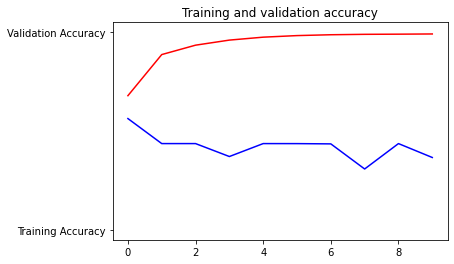

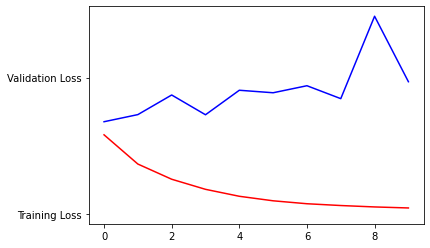

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

# IMDB subwords

In [17]:
import tensorflow as tf

import tensorflow_datasets as tfds
imdb, info = tfds.load('imdb_reviews/subwords8k', as_supervised=True, with_info=True)

In [18]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset, test_dataset = imdb['train'], imdb['test']

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

In [19]:
tokenizer = info.features['text'].encoder

In [20]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


## Preparing Model

In [21]:
import tensorflow as tf

embedding_dim = 64

model = tf.keras.Sequential([
            tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [22]:
num_epochs = 10
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 18s 47ms/step - loss: 0.6791 - accuracy: 0.6032 - val_loss: 0.6410 - val_accuracy: 0.7572
Epoch 2/10
391/391 [==============================] - 19s 48ms/step - loss: 0.5305 - accuracy: 0.8092 - val_loss: 0.4447 - val_accuracy: 0.8260
Epoch 3/10
391/391 [==============================] - 19s 48ms/step - loss: 0.3602 - accuracy: 0.8745 - val_loss: 0.3519 - val_accuracy: 0.8695
Epoch 4/10
391/391 [==============================] - 19s 48ms/step - loss: 0.2906 - accuracy: 0.8986 - val_loss: 0.3240 - val_accuracy: 0.8740
Epoch 5/10
391/391 [==============================] - 18s 47ms/step - loss: 0.2541 - accuracy: 0.9090 - val_loss: 0.3169 - val_accuracy: 0.8732
Epoch 6/10
391/391 [==============================] - 18s 47ms/step - loss: 0.2272 - accuracy: 0.9190 - val_loss: 0.3170 - val_accuracy: 0.8747
Epoch 7/10
391/391 [==============================] - 19s 47ms/step - loss: 0.2107 - accuracy: 0.9243 - val_loss: 0.3210 - val_accuracy:

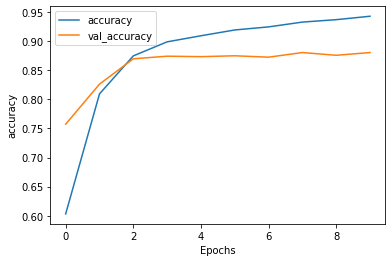

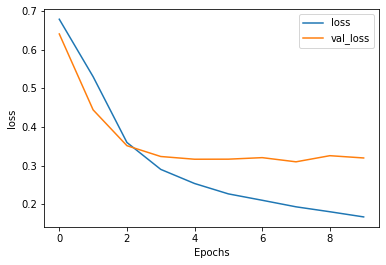

In [23]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")